Q-Learning on Non-Slippery FrozenLake

Install & Import

In [61]:
import gymnasium as gym
import random
import numpy as np
import matplotlib.pyplot as plt

The Frozen Lake Environment
 
We use `is_slippery=False` so actions are deterministic.

Q-Learning Training Loop

In [62]:
def train_agent(alpha=0.5, gamma=0.9, episodes=1000,
                epsilon=1.0, epsilon_decay=0.001, is_slippery=False):
    
    env = gym.make("FrozenLake-v1", is_slippery=is_slippery)
    nb_states  = env.observation_space.n
    nb_actions = env.action_space.n
    qtable     = np.zeros((nb_states, nb_actions))
    ep_rewards = []

    for _ in range(episodes):
        state, _ = env.reset()
        done  = False
        total_reward = 0

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(qtable[state])

            new_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            qtable[state, action] = qtable[state, action]+alpha * (
                reward + gamma * np.max(qtable[new_state]) - qtable[state, action]
            )

            state = new_state
            total_reward = total_reward+reward

        ep_rewards.append(total_reward)
        epsilon = max(epsilon - epsilon_decay, 0.01)

    env.close()
    return qtable, ep_rewards

Evaluation & Random Policy Functions


In [63]:
def evaluate_agent(qtable, eval_episodes=100):
    env = gym.make("FrozenLake-v1", is_slippery=False)
    nb_success = 0
    for _ in range(eval_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = np.argmax(qtable[state])
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            nb_success = nb_success+reward
    env.close()
    return nb_success / eval_episodes * 100


def random_policy(eval_episodes=100):
   
    env = gym.make("FrozenLake-v1", is_slippery=False)   
    nb_success = 0
    for _ in range(eval_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            nb_success = nb_success+reward
    env.close()
    return nb_success / eval_episodes * 100


def rolling_avg(data, window):
    return np.convolve(data, np.ones(window) / window, mode='valid')

 Train the Baseline Agent

**Hyperparameters:**
Hyperparameters:
alpha = 0.5
gamma = 0.9 
epsilon = 1.0  0.0 
episodes = 1000 

In [64]:
EPISODES      = 1000
ROLLING_WIN   = 50
EVAL_EPISODES = 100

print("Training baseline agent (alpha=0.5, gamma=0.9) ...")
qtable_base, rewards_base = train_agent(alpha=0.5, gamma=0.9, episodes=EPISODES)

agent_avg  = evaluate_agent(qtable_base, EVAL_EPISODES)
random_avg = random_policy(EVAL_EPISODES)

print(f"Baseline agent  avg reward over 100 test episodes: {agent_avg:.1f}%")
print(f"Random policy   avg reward over 100 test episodes: {random_avg:.1f}%")

Training baseline agent (alpha=0.5, gamma=0.9) ...
Baseline agent  avg reward over 100 test episodes: 100.0%
Random policy   avg reward over 100 test episodes: 0.0%


Reward Curve


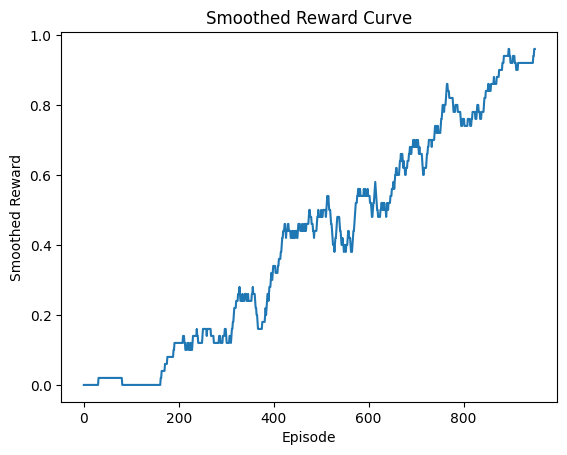

In [65]:
smoothed = rolling_avg(rewards_base, ROLLING_WIN)

plt.figure()

plt.plot(smoothed)

plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.title("Smoothed Reward Curve")

plt.show()


Hyperparameter Experiments

We sweep alpha and gammaindependently  
to see how each one affects convergence speed and final performance.

## Why I Picked These Hyperparameters

After running the sweep, I went with **alpha = 0.5** and **gamma = 0.9**.

**Learning rate (alpha):**
When I tried lower values like 0.1 or 0.3, the agent was just too slow — it barely improved even after 1000 episodes. On the other side, 0.7 and 0.9 were too jumpy, the reward kept going up and down instead of stabilizing. 0.5 felt like the sweet spot where it learned quickly but didn't go all over the place.

**Discount factor (gamma):**
With gamma = 0.5 the agent basically ignored the goal because the reward faded out too much by the time it reached the starting state. 0.99 worked okay but was a bit slow to get going. 0.9 worked best here — the goal reward was still strong enough to matter from the start, and the agent figured out the path well within the 1000 episode limit.

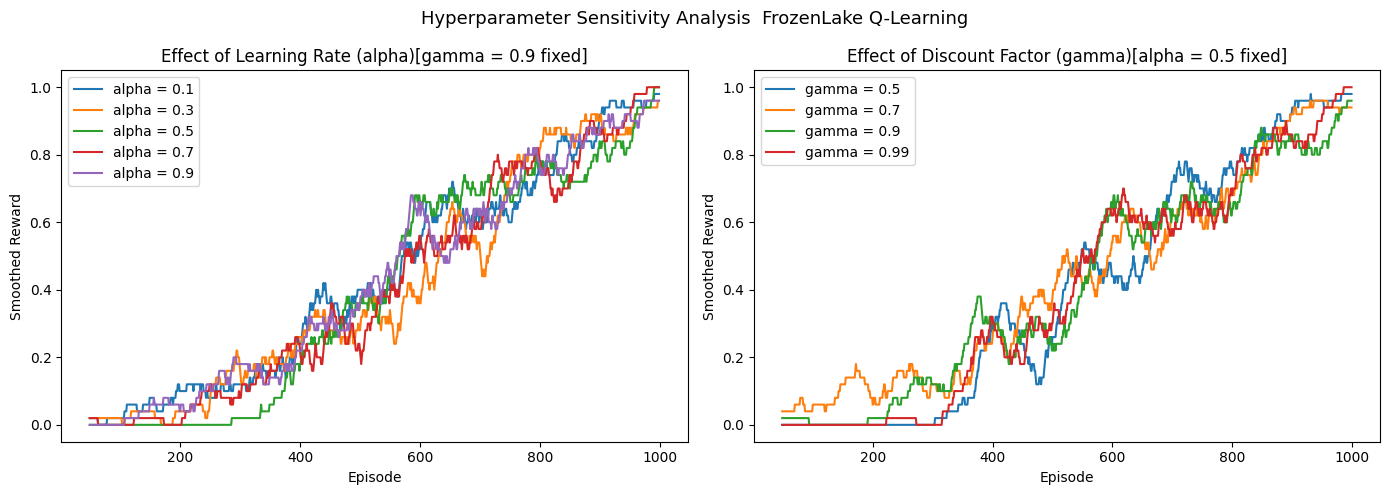

In [66]:
# Hyperparameter values to test
alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]
gamma_values = [0.5, 0.7, 0.9, 0.99]

alpha_curves = {}

for alpha in alpha_values:
    _, rewards = train_agent(alpha=alpha, gamma=0.9, episodes=EPISODES)
    smoothed_rewards = rolling_avg(rewards, ROLLING_WIN)
    alpha_curves[alpha] = smoothed_rewards

gamma_curves = {}

for gamma in gamma_values:
    _, rewards = train_agent(alpha=0.5, gamma=gamma, episodes=EPISODES)
    smoothed_rewards = rolling_avg(rewards, ROLLING_WIN)
    gamma_curves[gamma] = smoothed_rewards

episodes_range = range(ROLLING_WIN - 1, EPISODES)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for alpha, curve in alpha_curves.items():
    axes[0].plot(episodes_range, curve, label=f"alpha = {alpha}")

axes[0].set_title("Effect of Learning Rate (alpha)[gamma = 0.9 fixed]")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Smoothed Reward")
axes[0].legend()

for gamma, curve in gamma_curves.items():
    axes[1].plot(episodes_range, curve, label=f"gamma = {gamma}")

axes[1].set_title("Effect of Discount Factor (gamma)[alpha = 0.5 fixed]")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Smoothed Reward")
axes[1].legend()

plt.suptitle("Hyperparameter Sensitivity Analysis  FrozenLake Q-Learning", fontsize=13)

plt.tight_layout()
plt.savefig("hyperparameter_experiments.png", dpi=150)
plt.show()

 Q-Table

In [67]:
print("Q-table:")
print(qtable_base)

Q-table:
[[0.531441   0.59049    0.59049    0.531441  ]
 [0.531441   0.         0.6561     0.58610231]
 [0.58923151 0.729      0.51016331 0.64619048]
 [0.63853402 0.         0.4406113  0.31460446]
 [0.59049    0.6561     0.         0.531441  ]
 [0.         0.         0.         0.        ]
 [0.         0.81       0.         0.65609778]
 [0.         0.         0.         0.        ]
 [0.6561     0.         0.729      0.59049   ]
 [0.6561     0.81       0.81       0.        ]
 [0.729      0.9        0.         0.729     ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.80984157 0.9        0.72892975]
 [0.81       0.9        1.         0.81      ]
 [0.         0.         0.         0.        ]]


Winning Sequence

In [68]:
env = gym.make("FrozenLake-v1", is_slippery=False)
action_names = {0: "LEFT", 1: "DOWN", 2: "RIGHT", 3: "UP"}

state, _ = env.reset()
done     = False
sequence = []

while not done:
    action = np.argmax(qtable_base[state])
    sequence.append(action)
    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()

print("Winning sequence:", " → ".join(action_names[a] for a in sequence))
print("Number of steps :", len(sequence))
print("Final reward    :", reward)

N_EVAL   = 1000
wins     = 0
total_steps_list = []

eval_env = gym.make("FrozenLake-v1", is_slippery=False)

for ep in range(N_EVAL):
    state, _ = eval_env.reset()
    done     = False
    steps    = 0

    while not done:
        action = np.argmax(qtable_base[state])
        state, reward, terminated, truncated, _ = eval_env.step(action)
        done  = terminated or truncated
        steps = steps+1

    if reward == 1.0:
        wins = wins+1
        total_steps_list.append(steps)

eval_env.close()

win_rate   = wins / N_EVAL * 100
avg_steps  = np.mean(total_steps_list) if total_steps_list else 0

print(f"  Win Rate : {win_rate:.1f}%")


Winning sequence: DOWN → DOWN → RIGHT → DOWN → RIGHT → RIGHT
Number of steps : 6
Final reward    : 1
  Win Rate : 100.0%


## Reflection (200–300 words)

### What effect did changing the learning rate (alpha) or discount factor (gamma) have?

**Learning rate:**  
If the learning rate (alpha) is too low, like 0.1, the agent learns very slowly. It updates the Q-values only a little each time, so it takes many episodes before it really understands which actions are good. Because of this, the reward graph improves very late and looks noisy for a long time.

If alpha is too high, like 0.9, the agent learns too aggressively. Every new experience almost replaces what it learned before. This can make learning unstable, and the Q-values may keep changing up and down instead of settling.

In this environment, alpha around 0.5 worked best. It learns fast enough but still keeps learning stable, balancing new information with past experience.

**Discount factor:**  
If gamma is low, like 0.5, the agent only cares about immediate reward.
But in Frozen Lake, the reward comes only at the very end, after several steps. There is no reward in between.
So when gamma = 0.5, the future reward becomes very small by the time it reaches the starting state. It almost fades away. Because of this, the agent cannot clearly understand that reaching the goal is valuable. Learning becomes very difficult.
When gamma is high, like 0.9 or 0.99, the agent cares more about future rewards. The reward from the goal stays strong enough to influence earlier states.
This helps the agent learn that the path from the start to the goal is important.
So in Frozen Lake, a higher gamma is necessary because the reward is delayed until the final step.

### At what point in training did the agent start meaningfully improving and why?

With the basic settings (alpha = 0.5, gamma = 0.9, and epsilon slowly decreasing from 1.0), the agent usually reaches the goal once or twice randomly in the early episodes. But real improvement does not start immediately.
Around 100–200 episodes, epsilon becomes smaller, so the agent starts using what it has learned instead of moving randomly all the time. This is when performance begins to improve more consistently.
After about 300 episodes, the reward graph increases quickly. By around 500 episodes, the agent is winning almost every time.
This happens because epsilon reaches around 0.5, which is the point where the agent starts exploiting more than exploring. That shift helps the learning stabilize and improve rapidly.

Training agent on slippery environment...
Trained agent:    55.0% success rate
Random policy:    0.0% success rate
Improvement:     +55.0%


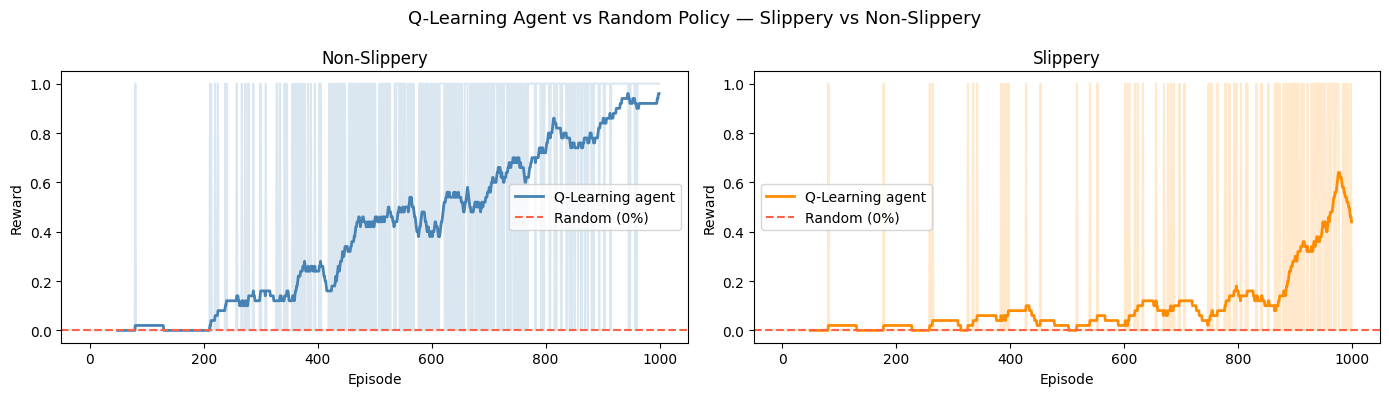

In [69]:
def random_policy_slippery(eval_episodes=100):
    env = gym.make("FrozenLake-v1", is_slippery=True)
    successes = 0

    for _ in range(eval_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()  # just flailing around
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            successes += reward

    env.close()
    return successes / eval_episodes * 100


def evaluate_agent_slippery(qtable, eval_episodes=100):
    env = gym.make("FrozenLake-v1", is_slippery=True)
    successes = 0

    for _ in range(eval_episodes):
        state, _ = env.reset()
        done = False
        while not done:
            action = np.argmax(qtable[state])  # pick the best known move
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            successes += reward

    env.close()
    return successes / eval_episodes * 100

print("Training agent on slippery environment...")
qtable_slippery, rewards_slippery = train_agent(
    alpha=0.5,
    gamma=0.99,
    episodes=1000,
    epsilon=1.0,
    epsilon_decay=0.001,
    is_slippery=True,
)

agent_score  = evaluate_agent_slippery(qtable_slippery, eval_episodes=100)
random_score = random_policy_slippery(eval_episodes=100)

print(f"Trained agent:    {agent_score:.1f}% success rate")
print(f"Random policy:    {random_score:.1f}% success rate")
print(f"Improvement:     +{agent_score - random_score:.1f}%")


smoothed_base = rolling_avg(rewards_base, ROLLING_WIN)
smoothed_slip = rolling_avg(rewards_slippery, ROLLING_WIN)

fig, (ax_base, ax_slip) = plt.subplots(1, 2, figsize=(14, 4))

# Non-slippery panel
ax_base.plot(rewards_base, alpha=0.2, color="steelblue")
ax_base.plot(
    range(ROLLING_WIN - 1, len(rewards_base)), smoothed_base,
    color="steelblue", linewidth=2, label="Q-Learning agent",
)
ax_base.axhline(random_avg / 100, color="tomato", linestyle="--",
                label=f"Random ({random_avg:.0f}%)")
ax_base.set_title("Non-Slippery")
ax_base.set_xlabel("Episode")
ax_base.set_ylabel("Reward")
ax_base.legend()

ax_slip.plot(rewards_slippery, alpha=0.2, color="darkorange")
ax_slip.plot(
    range(ROLLING_WIN - 1, len(rewards_slippery)), smoothed_slip,
    color="darkorange", linewidth=2, label="Q-Learning agent",
)
ax_slip.axhline(random_score / 100, color="tomato", linestyle="--",
                label=f"Random ({random_score:.0f}%)")
ax_slip.set_title("Slippery")
ax_slip.set_xlabel("Episode")
ax_slip.set_ylabel("Reward")
ax_slip.legend()

fig.suptitle("Q-Learning Agent vs Random Policy — Slippery vs Non-Slippery", fontsize=13)
plt.tight_layout()
plt.savefig("slippery_comparison.png", dpi=150)
plt.show()